In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [4]:
data.iloc[1:10, 28:45]

,Hour,Day of Week (Number),Day of Week (String),Is_English,Detected_Language,Image_Count,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10
1,20,6,Sunday,True,en,1,1.257535,4.292836,0.637026,0.038215,0.341019,0.103195,0.023346,0.352497,0.099513,0.015858,0.282103
2,15,6,Sunday,True,en,1,1.015909,4.928564,0.049328,1.360145,0.188817,0.242184,1.370974,0.206735,0.089321,0.008390,0.464875
3,18,2,Wednesday,True,en,7,0.612580,2.573719,0.000000,0.000000,1.416055,0.397631,1.642256,0.049719,0.000707,0.285212,0.627529
4,19,5,Saturday,True,en,1,0.961807,3.994127,0.116529,1.330238,0.034433,2.436250,0.633051,0.620503,3.313558,0.000000,0.139836
5,6,6,Sunday,False,ko,3,0.024685,0.956713,0.100529,0.715106,0.565287,0.084047,0.267570,0.000000,0.030411,0.600792,0.018151
6,15,6,Sunday,False,ko,2,0.000000,1.686701,0.022357,0.000000,0.007881,0.025374,0.328463,0.324222,0.000000,0.042074,0.056771
7,3,6,Sunday,False,ko,10,0.272321,1.318672,0.063117,0.000000,0.127826,0.154153,0.012882,0.257812,0.000000,0.082779,0.027158
8,3,6,Sunday,False,ko,10,1.009356,0.572479,0.049320,0.017962,0.707233,0.036858,0.366499,0.633115,0.058597,0.069269,0.271958
9,21,6,Sunday,True,en,1,1.316597,1.515859,0.067210,2.473874,0.316460,0.163660,0.673739,0.901117,0.219723,1.258277,0.542950


In [5]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Followees', 'Posts', 'Is_English', 'Image_Count']

# Combine both lists of columns to keep
columns_to_keep = additional_columns_to_keep #text_columns + image_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2 = data_2[data_2['Image_Count'] <= 1]
data_2.head(10)

,Username,post_id,like_count,comment_count,Followers,Followees,Posts,Is_English,Image_Count
0,00_rocketgirl,1354915397698488656,293,6,6453,710,1059,True,1
1,00_rocketgirl,1666974101448132749,73,2,6453,710,1059,True,1
2,00_rocketgirl,1768273356099895999,164,4,6453,710,1059,True,1
4,00_rocketgirl,1899586748141399903,116,2,6453,710,1059,True,1
9,0hkris,1514786978688118458,269,0,12630,7069,261,True,1
10,0hkris,1837331879491417999,1065,19,12630,7069,261,True,1
11,0hkris,1840089921320547693,1242,7,12630,7069,261,True,1
12,0hkris,1847365723795798774,1346,4,12630,7069,261,True,1
13,0ldisme,1653111532051112326,1139,28,18583,523,487,True,1
14,0ldisme,1708204647056992205,1352,39,18583,523,487,True,1


In [6]:
# Filter the DataFrame to keep only observations where 'Is_English' is True
data_2 = data_2[data_2['Is_English'] == True]

Step 1: group and split the data by post_id

Define a popularity variable

In [7]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

Let's split the data!

In [8]:
# Define the number of iterations and an array to store accuracies
n_iterations = 7
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Normalize the selected features
    columns_to_normalize = ['Followers', 'Followees', 'Posts']
    scaler = StandardScaler().fit(train_data[columns_to_normalize])
    train_data.loc[:, columns_to_normalize] = scaler.transform(train_data[columns_to_normalize])
    val_data.loc[:, columns_to_normalize] = scaler.transform(val_data[columns_to_normalize])
    test_data.loc[:, columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets into DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    eval_list = [(dtrain, 'train'), (dval, 'val')]
    bst = xgb.train(params, dtrain, num_boost_round=500, evals=eval_list, early_stopping_rounds=20)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(dtest)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[0]	train-error:0.34537	val-error:0.36826
[1]	train-error:0.34111	val-error:0.37134
[2]	train-error:0.33862	val-error:0.36307
[3]	train-error:0.33609	val-error:0.36887
[4]	train-error:0.33542	val-error:0.36588
[5]	train-error:0.33552	val-error:0.36879
[6]	train-error:0.33511	val-error:0.36835
[7]	train-error:0.33478	val-error:0.36958
[8]	train-error:0.33461	val-error:0.37195
[9]	train-error:0.33292	val-error:0.37187
[10]	train-error:0.33306	val-error:0.37398
[11]	train-error:0.33273	val-error:0.37521
[12]	train-error:0.33209	val-error:0.37495
[13]	train-error:0.33195	val-error:0.37495
[14]	train-error:0.33220	val-error:0.37451
[15]	train-error:0.33199	val-error:0.37521
[16]	train-error:0.33070	val-error:0.37495
[17]	train-error:0.32933	val-error:0.37424
[18]	train-error:0.32866	val-error:0.36984
[19]	train-error:0.32851	val-error:0.37063
[20]	train-error:0.32867	val-error:0.36931
[21]	train-error:0.32865	val-error:0.36870
[22]	train-error:0.32805	val-error:0.36896
Accuracy 

In [9]:
import numpy as np
from scipy.stats import sem, t
from scipy import mean

# Assuming accuracies are stored in the 'accuracies' list as per previous example
accuracies = np.array(accuracies)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)

# Calculate the standard error of the mean
std_error = sem(accuracies)

# Determine the size of the accuracies array
n = len(accuracies)

# Use the t-distribution to calculate a 95% confidence interval
confidence = 0.95
h = std_error * t.ppf((1 + confidence) / 2, n - 1)

# Print the mean accuracy and confidence interval
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"95% Confidence interval: {mean_accuracy - h:.5f} - {mean_accuracy + h:.5f}")

Mean Accuracy: 0.65
95% Confidence interval: 0.64072 - 0.65680


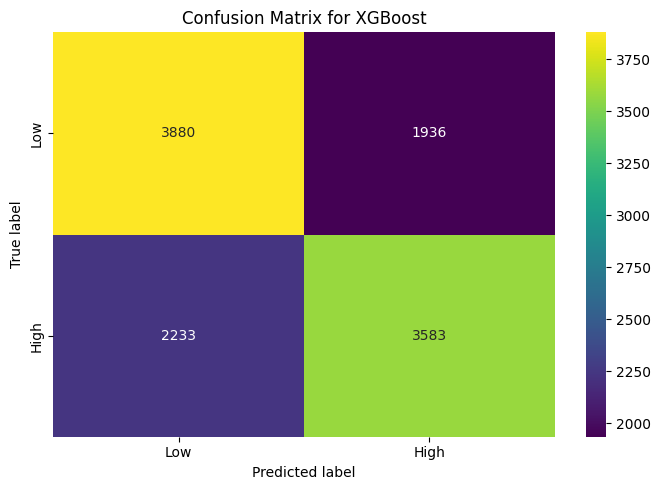

              precision    recall  f1-score   support

         Low       0.63      0.67      0.65      5816
        High       0.65      0.62      0.63      5816

    accuracy                           0.64     11632
   macro avg       0.64      0.64      0.64     11632
weighted avg       0.64      0.64      0.64     11632



In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, type_of_model):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title(f'Confusion Matrix for {type_of_model}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage assuming X_val is a pandas DataFrame and val_data['popularity'] is the true labels
evaluate_model(bst, X_val, val_data['popularity'], 'XGBoost')

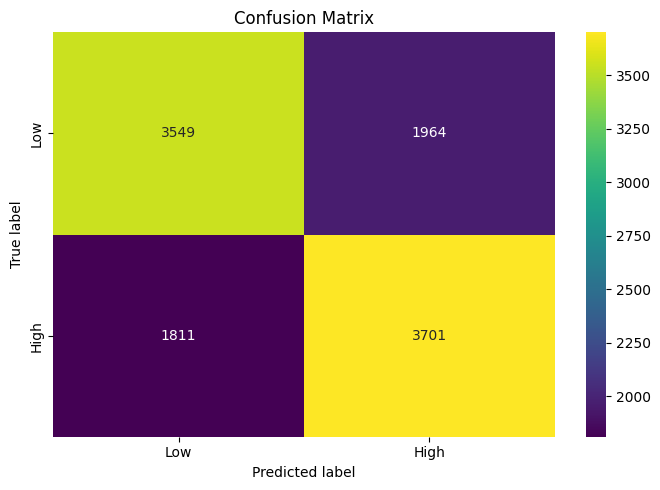

              precision    recall  f1-score   support

         Low       0.66      0.64      0.65      5513
        High       0.65      0.67      0.66      5512

    accuracy                           0.66     11025
   macro avg       0.66      0.66      0.66     11025
weighted avg       0.66      0.66      0.66     11025



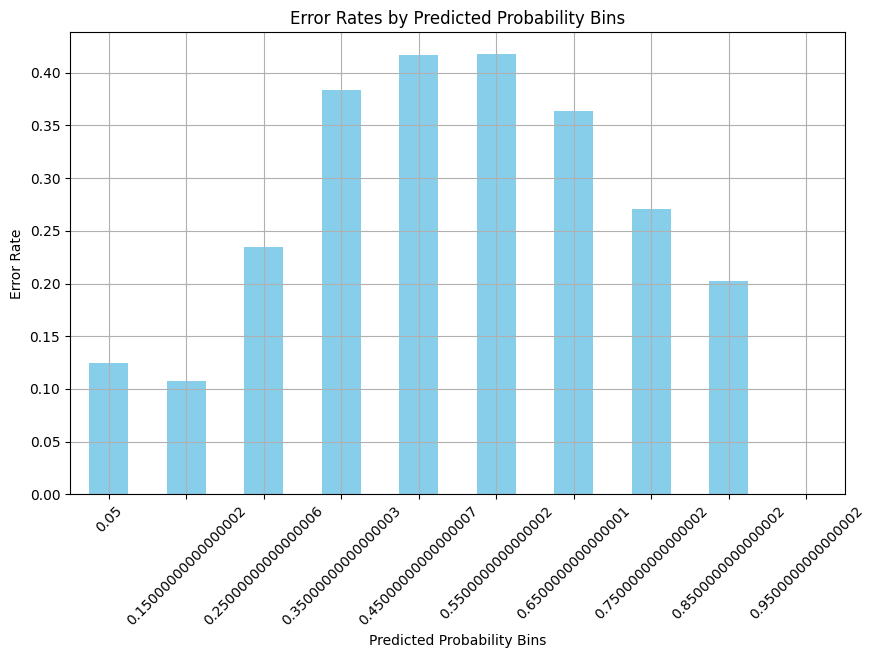

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage, assuming X_test is a pandas DataFrame and test_data['popularity'] is the true labels
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])